In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

Final Counts for the Last Step:
{'0100': 116, '0000': 164, '1010': 51, '0010': 341, '1110': 41, '1100': 91, '0110': 65, '1000': 131}
[0.164 0.    0.341 0.    0.116 0.    0.065 0.    0.131 0.    0.051 0.
 0.091 0.    0.041 0.   ]
Hash Value: 0011001101000000000000000001101010100100000000000000001001000100000000000000000001010001010000000000000000101000111100000000000000000011111110100000000000000001110001110000000000000000001100110100000000000000


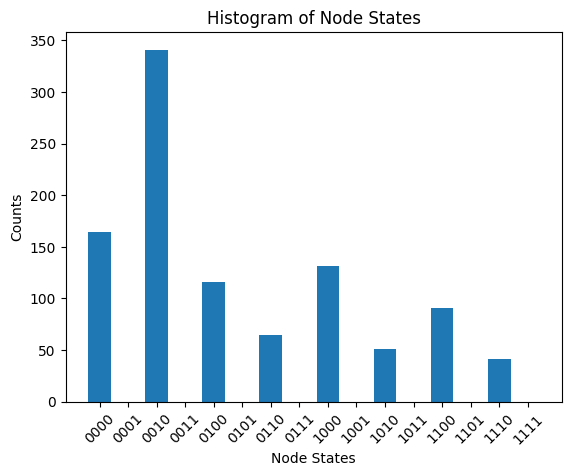

In [25]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import U3Gate


# Define the message and ensure it has an even number of bits
original_message = "00110011010101010101010011000111"
if len(original_message) % 2 != 0:
    original_message += "0"
    
steps = 2  # Number of steps, corresponding to the length of the message
n = 4  # Number of quantum positions

qpos = QuantumRegister(n, 'qc')
qcoin = QuantumRegister(1, 'qanc')
cpos = ClassicalRegister(n, 'cr')
circuit = QuantumCircuit(qpos, qcoin, cpos)
    

initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
initial_state = U3Gate(initial_angle, 0, 0)
circuit.append(initial_state, [qcoin])


# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts, n):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    
    # Create array of probability values in reverse order
    probabilities = np.zeros(2 ** n)
    for i, state in enumerate(states):
        index = int(state, 2)
        probabilities[index] = state_counts[i]
    
    probabilities /= nshots
    return probabilities




def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()

def run_quantum_coin_walk(message, steps):
    simulatorType = 'quantum'
    simulator = Aer.get_backend('qasm_simulator')

    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
    circuit.measure(qpos, cpos)

    job = execute(circuit, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

seed = 12
random.seed(seed)
np.random.seed(seed)

counts = run_quantum_coin_walk(original_message, steps)

# Reverse the order of node states in the counts dictionary
reversed_counts = {state[::-1]: count for state, count in counts.items()}

print("Final Counts for the Last Step:")
print(reversed_counts)

probabilities = counts_to_prob_1d(reversed_counts,n)
print(probabilities)

hash_value = ""
scaling_factor = 10**4
# Calculate the binary strings for each probability
binary_strings = [bin(int(prob * scaling_factor))[2:].zfill(13) for prob in probabilities]

# Concatenate the binary strings to obtain the hash value
hash_value = "".join(binary_strings)

print("Hash Value:", hash_value)


import matplotlib.pyplot as plt

def plot_histogram(counts):
    # Create a list of all possible node states from "000" to "111"
    all_states = [format(i, '04b') for i in range(16)]

    # Initialize counts for all states with 0 if not present in 'counts'
    state_counts = [counts[state] if state in counts else 0 for state in all_states]

    plt.bar(all_states, state_counts)
    plt.xlabel('Node States')
    plt.ylabel('Counts')
    plt.title('Histogram of Node States')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.show()

# Assuming you already have the 'counts' dictionary
plot_histogram(reversed_counts)

In [26]:

hash_value = ""
scaling_factor = 10**4

binary_strings = [bin(int(prob * scaling_factor))[2:].zfill(13) for prob in probabilities]

# Concatenate the binary strings to obtain the hash value
hash_value = "".join(binary_strings)

print("Hash Value:", hash_value)



Hash Value: 0011001101000000000000000001101010100100000000000000001001000100000000000000000001010001010000000000000000101000111100000000000000000011111110100000000000000001110001110000000000000000001100110100000000000000


In [37]:
run_quantum_coin_walk("1010101010000111", 4)[1].draw('mpl')

Traceback (most recent call last):
  Cell In[37], line 1
    run_quantum_coin_walk("1010101010000111", 4)[1].draw('mpl')
KeyError: 1

Use %tb to get the full traceback.


In [28]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor

# Define the message and ensure it has an even number of bits
original_message = "001101100100110011001110101010101011101001"
if len(original_message) % 2 != 0:
    original_message += "0"
    
conditions = [
    original_message,
    original_message.replace("0", "1", 1),  # Change a 0 to 1
    original_message.replace("1", "0", 1),  # Change a 1 to 0
    original_message[1:],  # Delete the first bit
    original_message[:4] + "1" + original_message[4:],  # Insert a bit randomly
]
# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts, n):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    
    # Create array of probability values in reverse order
    probabilities = np.zeros(2 ** n)
    for i, state in enumerate(states):
        index = int(state, 2)
        probabilities[index] = state_counts[i]
    
    probabilities /= nshots
    return probabilities


def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()
    
def run_quantum_coin_walk(message, steps):
    simulatorType = 'quantum'
    simulator = Aer.get_backend('qasm_simulator')

    qpos = QuantumRegister(n, 'qc')
    qcoin = QuantumRegister(1, 'qanc')
    cpos = ClassicalRegister(n, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)
    
    for i in range(len(message)//2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
    circuit.measure(qpos, cpos)

    job = execute(circuit, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

seed = 12
random.seed(seed)
np.random.seed(seed)

steps = 2  # Number of steps, corresponding to the length of the message
n = 4  # Number of quantum positions

for i, condition_message in enumerate(conditions, start=1):
    counts = run_quantum_coin_walk(condition_message, steps)

    # Reverse the order of node states in the counts dictionary
    reversed_counts = {state[::-1]: count for state, count in counts.items()}

    print("Final Counts for the Last Step:")
    print(reversed_counts)

    probabilities = counts_to_prob_1d(reversed_counts,n)
    print(probabilities)

    hash_value = ""
    scaling_factor = 10**4

    # Calculate the binary strings for each probability
    binary_strings = [bin(int(prob * scaling_factor))[2:].zfill(13) for prob in probabilities]

    # Concatenate the binary strings to obtain the hash value
    hash_value = "".join(binary_strings)

    print(f"Condition {i} (Binary): {hash_value}")

Final Counts for the Last Step:
{'0111': 4, '1011': 14, '1111': 66, '0101': 76, '0001': 32, '0011': 99, '1001': 622, '1101': 87}
[0.    0.032 0.    0.099 0.    0.076 0.    0.004 0.    0.622 0.    0.014
 0.    0.087 0.    0.066]
Condition 1 (Binary): 0000000000000000010100000000000000000000001111011110000000000000000010111110000000000000000000000010100000000000000001100001001100000000000000000000100011000000000000000000110110010100000000000000001010010100
Final Counts for the Last Step:
{'1011': 6, '1111': 60, '0101': 102, '0011': 9, '0001': 42, '1001': 379, '1101': 170, '0111': 232}
[0.    0.042 0.    0.009 0.    0.102 0.    0.232 0.    0.379 0.    0.006
 0.    0.17  0.    0.06 ]
Condition 2 (Binary): 0000000000000000011010010000000000000000000001011010000000000000000011111110110000000000000010010001000000000000000000111011001110000000000000000000001111000000000000000001101010010000000000000000001001011000
Final Counts for the Last Step:
{'0111': 1, '1011': 98, '1101': 134, '1111': 76,

In [34]:
import numpy as np
import random
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute

# Define the message and ensure it has an even number of bits
original_message = "1010101010000111010101110101000101010"
original_message += "0" if len(original_message) % 2 != 0 else ""

n = 4

# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    operators = [coin_operator_C1, coin_operator_C2, coin_operator_C3, coin_operator_C4]
    selected_operator = operators[int(message_bits, 2)]
    circuit.unitary(selected_operator(), [qcoin])

def counts_to_prob_1d(counts, n):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    
    # Create array of probability values in reverse order
    probabilities = np.zeros(2 ** n)
    for i, state in enumerate(states):
        index = int(state, 2)
        probabilities[index] = state_counts[i]
    
    probabilities /= nshots
    return probabilities


def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mct([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()

# Function to perform the quantum coin walk and generate hash values
def run_quantum_coin_walk(message, n):
    simulator = Aer.get_backend('qasm_simulator')
    qpos = QuantumRegister(n, 'qc')
    qcoin = QuantumRegister(1, 'qanc')
    cpos = ClassicalRegister(n, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos)

    for i in range(len(message)//2):
        message_bits = message[i * 2:i * 2 + 2]
        step(circuit, qpos, qcoin, message_bits)

    circuit.measure(qpos, cpos)

    job = execute(circuit, simulator, shots=1000)
    result = job.result()
    counts = result.get_counts(circuit)
    return counts

def generate_hash_from_counts(counts, n):
    probabilities = counts_to_prob_1d(counts, n)
    hash_value = "".join([bin(int(prob * 10**4))[2:] for prob in probabilities])
    return hash_value

def calculate_changed_bits(hash_value1, hash_value2):
    changed_bits = sum(bit1 != bit2 for bit1, bit2 in zip(hash_value1, hash_value2))
    added_zero_bits=0;
    added_zero_bits += max(0, 208 - len(hash_value2))
    return changed_bits, added_zero_bits

def perform_diffusion_confusion_tests(N, message, n):
    original_counts = run_quantum_coin_walk(message, n)
    o_reversed_counts = {state[::-1]: count for state, count in original_counts.items()}
    original_hash = generate_hash_from_counts(o_reversed_counts, n)

    BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = [], [], [], [], [], []

    for i in range(N):
        modified_message = modify_message_randomly(message)
        modified_counts = run_quantum_coin_walk(modified_message, n)
        m_reversed_counts = {state[::-1]: count for state, count in modified_counts.items()}
        modified_hash = generate_hash_from_counts(m_reversed_counts, n)

        changed_bits, added_zero_bits = calculate_changed_bits(original_hash, modified_hash)

        BBN = changed_bits
        AAN = added_zero_bits
        TAB = BBN + AAN
        PT = (TAB / 208) * 100
        TN = (BBN - (PT / 100) * (208 - len(original_hash)))
        PN = (PT - (BBN / 208) * 100)

        BBN_list.append(BBN)
        AAN_list.append(AAN)
        TAB_list.append(TAB)
        PT_list.append(PT)
        TN_list.append(TN)
        PN_list.append(PN)

    return BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list

def modify_message_randomly(message):
    message_length=len(message)
    return ''.join(random.choice('01') for _ in range(message_length))

def calculate_total_collisions(N, message, n):
    collision_count = 0

    for i in range(N):
        original_counts = run_quantum_coin_walk(message, n)
        o_reversed_counts = {state[::-1]: count for state, count in original_counts.items()}
        original_hash = generate_hash_from_counts(o_reversed_counts, n)

        modified_message = modify_message_randomly(message)
        modified_counts = run_quantum_coin_walk(modified_message, n)
        m_reversed_counts = {state[::-1]: count for state, count in modified_counts.items()}
        modified_hash = generate_hash_from_counts(m_reversed_counts, n)

        matching_count = sum(c1 == c2 for c1, c2 in zip(original_hash, modified_hash))

        if matching_count > 0:
            collision_count += 1

    return collision_count

N_values = [1024]
N_collision_test = 1001

for N in N_values:
    BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = perform_diffusion_confusion_tests(N, original_message, n)

    variance_TAB = np.var(TAB_list, ddof=0)
    variance_PN = np.var(PT_list, ddof=0)

    total_collision_count = calculate_total_collisions(N_collision_test, original_message, n)
    collision_rate = total_collision_count / N_collision_test

    print(f"N = {N}")
    print("Mean BBN:", np.mean(BBN_list))
    print("Mean AAN:", np.mean(AAN_list))
    print("Mean TAB:", np.mean(TAB_list))
    print("Mean PT (%):", np.mean(PT_list))
    print("Variance TAB:", variance_TAB)
    print("Variance PN:", variance_PN)
    print(f"Total Collision Count: {total_collision_count}")
    print(f"Collision Rate: {collision_rate:.4f}")


N = 1024
Mean BBN: 40.150390625
Mean AAN: 119.83984375
Mean TAB: 159.990234375
Mean PT (%): 76.91838191105768
Variance TAB: 27.39638900756836
Variance PN: 6.332375417799637
Total Collision Count: 1001
Collision Rate: 1.0000
